In [1]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import RFE

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

import re

import time

C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
features,y = preprocessing.load_feature_data()

classifier__num_leaves = 80
classifier__n_estimators = 250
classifier__max_depth = 7
classifier__boosting_type = 'goss'
augmenter__fdr_level = 0.03


lgbm = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',LGBMClassifier(random_state=42,n_jobs=5,device_type = 'gpu',max_bin = 64,num_leaves=classifier__num_leaves,
    n_estimators=classifier__n_estimators,max_depth=classifier__max_depth,boosting_type=classifier__boosting_type,random_seed=42)),
])

y_temp = y.loc[y.index.isin(features.index)]
features = features.loc[y_temp.index]
x_array = np.array(features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)))
y_array = np.array(y_temp["label_shifted"])

lgbm.fit(x_array,y_array)

relevant_feature_names = features.iloc[:,lgbm.named_steps["augmenter"].relevant_features].columns

relevant_feature_lgbm_importance = lgbm["classifier"].feature_importances_

dict_relevant_features = {"feature": relevant_feature_names,
                         "lgbm_importance":relevant_feature_lgbm_importance}

df_relevant_features = pd.DataFrame(dict_relevant_features)

[LightGBM] [Warning] seed is set with random_seed=42, random_state=42 will be ignored. Current value: seed=42


In [3]:
relevant_feature_names

Index(['temperature__sum_values',
       'temperature__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'temperature__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"',
       'temperature__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
       'temperature__cwt_coefficients__coeff_9__w_5__widths_(2, 5, 10, 20)',
       ...
       'temperature__symmetry_looking__r_0.65',
       'temperature__symmetry_looking__r_0.6000000000000001',
       'temperature__fft_coefficient__attr_"real"__coeff_4',
       'temperature__symmetry_looking__r_0.2',
       'temperatu

In [4]:
from lightgbm import plot_tree
import graphviz

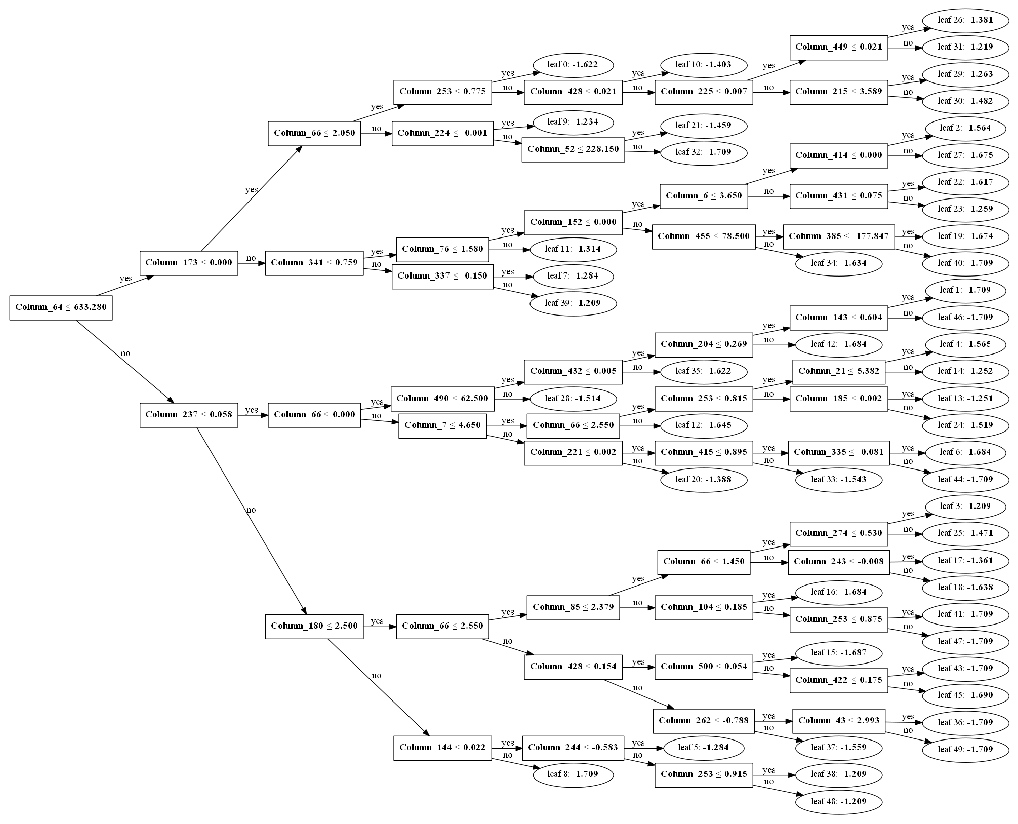

In [5]:
plot_tree(lgbm["classifier"],figsize=(18,18))

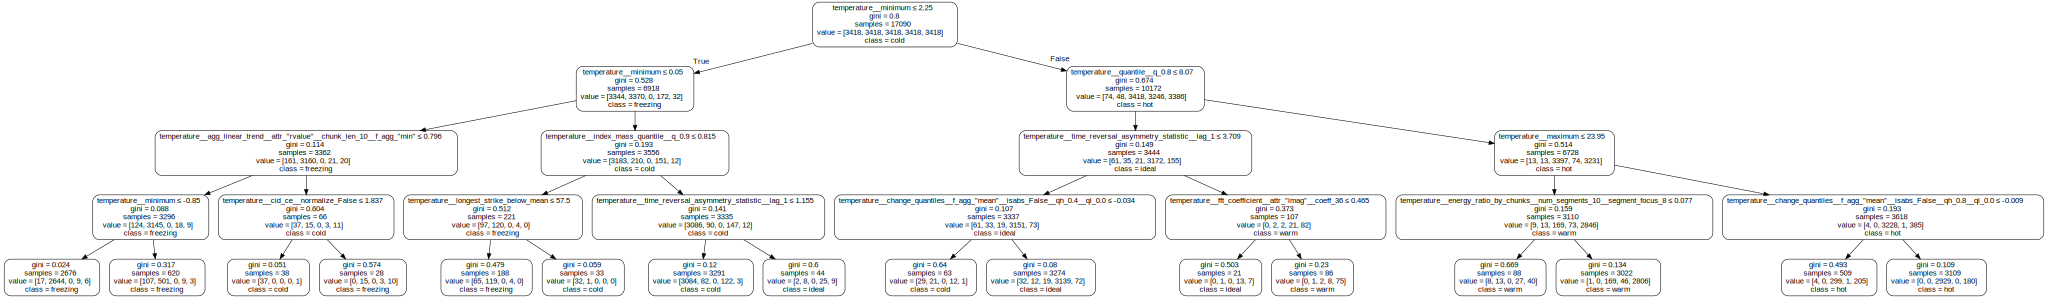

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 

clf_tree = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',tree.DecisionTreeClassifier(random_state=42,max_depth=4))])
#clf_tree = tree.DecisionTreeClassifier(random_state=42,max_depth=4)


clf_tree.fit(X=features,y=y_temp["label_shifted"])

names = list(y_temp["label_shifted"].unique())
names.sort()
tree_dir = r'C:\Users\AliHa\Desktop\Masters Project\medangel\reports\figures\tree.pdf'
dot_data = tree.export_graphviz(clf_tree['classifier'],
                     #out_file=tree_dir,
                     feature_names = clf_tree.named_steps["augmenter"].relevant_features,
                     class_names = names,
                     filled = False,
                     rounded=True,
                     special_characters = True,
                     rotate=False
                     )
graph = graphviz.Source(dot_data)
graph


In [7]:
from sklearn.metrics import confusion_matrix

In [8]:
confusion_matrix(y_temp["label_shifted"],clf_tree.predict(features))

array([[ 11861,    746,      9,    115,     29],
       [   161,   5228,      0,     32,     19],
       [     0,      0,   3228,     19,    171],
       [ 18597,   2835,    266, 376642,  11081],
       [    80,    291,   5675,   1753,  47484]], dtype=int64)

In [9]:
clf_tree["classifier"].classes_

array(['cold', 'freezing', 'hot', 'ideal', 'warm'], dtype=object)

In [10]:
y_pred = clf_tree.predict(features)

In [11]:
ideal = y_temp["label_shifted"] == "ideal"

In [12]:
ideal_tp = np.logical_and(ideal,y_pred == "ideal")

In [13]:
np.sum(ideal_tp)

376642

In [14]:
features[ideal_tp]

temperature__variance_larger_than_standard_deviation  \
59497 109                                                 1.0      
      110                                                 1.0      
      111                                                 1.0      
      112                                                 1.0      
      113                                                 1.0      
...                                                       ...      
59519 1852                                                0.0      
      1853                                                0.0      
      1854                                                0.0      
      1855                                                0.0      
      1856                                                0.0      

            temperature__has_duplicate_max  temperature__has_duplicate_min  \
59497 109                              1.0                             0.0   
      110                              1.0                             0.0   
      111                              1.0                             0.0   
      112                              1.0                             0.0   
      113                              1.0                             0.0   
...                                    ...                             ...   
59519 1852                             1.0                             1.0   
      1853                             1.0                             1.0   
      1854                             1.0                             1.0   
      1855                             1.0                             1.0   
      1856                             1.0                             1.0   

            temperature__has_duplicate  temperature__sum_values  \
59497 109                          1.0                    523.2   
      110                          1.0                    523.7   
      111                          1.0                    524.3   
      112                          1.0                    525.1   
      113                          1.0                    526.0   
...                                ...                      ...   
59519 1852                         1.0                    259.0   
      1853                         1.0                    258.4   
      1854                         1.0                    257.8   
      1855                         1.0                    257.2   
      1856                         1.0                    256.6   

            temperature__abs_energy  temperature__mean_abs_change  \
59497 109                   3162.88                      0.158586   
      110                   3170.93                      0.156566   
      111                   3180.41                      0.154545   
      112                   3192.73                      0.153535   
      113                   3206.32                      0.152525   
...                             ...                           ...   
59519 1852                   673.26                      0.014141   
      1853                   670.14                      0.014141   
      1854                   667.02                      0.014141   
      1855                   663.90                      0.014141   
      1856                   660.78                      0.014141   

            temperature__mean_change  \
59497 109                   0.005051   
      110                   0.007071   
      111                   0.009091   
      112                   0.010101   
      113                   0.011111   
...                              ...   
59519 1852                 -0.006061   
      1853                 -0.006061   
      1854                 -0.006061   
      1855                 -0.006061   
      1856                 -0.006061   

            temperature__mean_second_derivative_central  temperature__median  \
59497 109                                      0.001020        

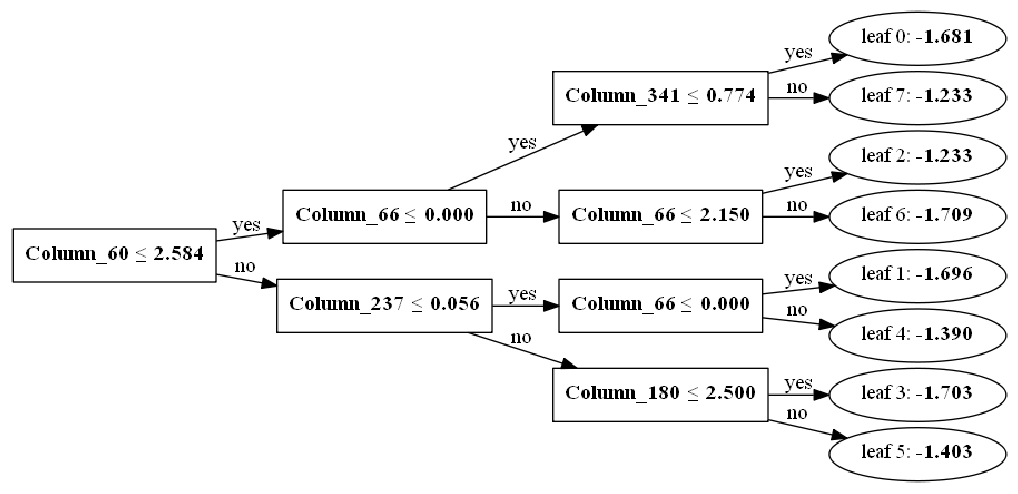

In [15]:
lgbm_small = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',LGBMClassifier(random_state=42,n_jobs=5,max_depth=3,boosting_type='gbdt',random_seed=42)),
])

lgbm_small.fit(x_array,y_array)


plot_tree(lgbm_small["classifier"],figsize=(18,18))

In [16]:
names = list(y_temp["label_shifted"].unique())

In [17]:
names.sort()

In [18]:
names

['cold', 'freezing', 'hot', 'ideal', 'warm']

In [19]:
list(y_temp["label_shifted"].unique())

['warm', 'ideal', 'cold', 'freezing', 'hot']

In [20]:
top5 = ['temperature__minimum',
        'temperature__maximum',
        'temperature__benford_correlation',
        'temperature__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
        'temperature__quantile__q_0.1']

In [21]:
x_top5 = features.loc[:,top5]

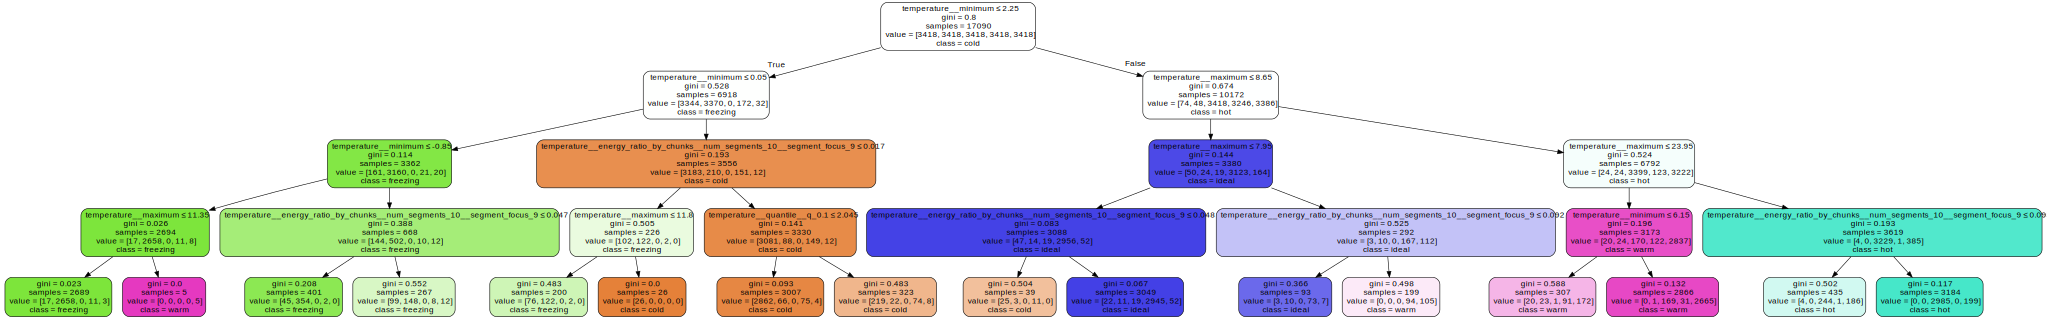

In [22]:
clf_top5 = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',tree.DecisionTreeClassifier(random_state=42,max_depth=4))])
#clf_tree = tree.DecisionTreeClassifier(random_state=42,max_depth=4)


clf_top5.fit(X=x_top5,y=y_temp["label_shifted"])

names = list(y_temp["label_shifted"].unique())
names.sort()
tree_dir = r'C:\Users\AliHa\Desktop\Masters Project\medangel\reports\figures\tree.gv'
dot_data = tree.export_graphviz(clf_top5['classifier'],
                     #out_file=tree_dir,
                     feature_names = clf_top5.named_steps["augmenter"].relevant_features,
                     class_names = names,
                     filled = True,
                     rounded=True,
                     special_characters = True,
                     rotate=False
                     )
graph = graphviz.Source(dot_data)
graph


In [23]:
graph.render(tree_dir,view=True)

'C:\\Users\\AliHa\\Desktop\\Masters Project\\medangel\\reports\\figures\\tree.gv.pdf'

In [24]:
print(clf_top5["classifier"].classes_)
confusion_matrix(y_temp["label_shifted"],clf_top5.predict(x_top5))

['cold' 'freezing' 'hot' 'ideal' 'warm']


array([[ 11698,    903,      9,    103,     47],
       [   140,   5234,      0,     32,     34],
       [     0,      0,   3229,     19,    170],
       [ 20375,   2622,    319, 360680,  25425],
       [   336,    215,   5675,    813,  48244]], dtype=int64)

In [25]:
y_pred = clf_top5.predict(x_top5)
ideal = y_temp["label_shifted"] == "ideal"
ideal_tp = np.logical_and(ideal,y_pred == "ideal")
ideal_tp_features = x_top5[ideal_tp]
ideal_fn = np.logical_and(ideal,y_pred != "ideal")
ideal_fn_features = x_top5[ideal_fn]

In [26]:
ideal_tp_features

temperature__minimum  temperature__maximum  \
59497 213                    6.0                   7.8   
      214                    6.0                   7.6   
      215                    6.0                   7.5   
      216                    6.0                   7.4   
      217                    6.0                   7.5   
...                          ...                   ...   
59519 1852                   2.3                   2.9   
      1853                   2.3                   2.9   
      1854                   2.3                   2.9   
      1855                   2.3                   2.9   
      1856                   2.3                   2.9   

            temperature__benford_correlation  \
59497 213                          -0.333274   
      214                          -0.333274   
      215                          -0.333274   
      216                          -0.333274   
      217                          -0.333274   
...                                      ...   
59519 1852                          0.295657   
      1853                          0.295657   
      1854                          0.295657   
      1855                          0.295657   
      1856                          0.295657   

            temperature__energy_ratio_by_chunks__num_segments_10__segment_focus_9  \
59497 213                                            0.112141                       
      214                                            0.112902                       
      215                                            0.113590                       
      216                                            0.113937                       
      217                                            0.114491                       
...                                                       ...                       
59519 1852                                           0.081365                       
      1853                                           0.081043                       
      1854                                           0.080717                       
      1855                                           0.080389                       
      1856                                           0.080057                       

            temperature__quantile__q_0.1  
59497 213                           6.00  
      214                           6.00  
      215                           6.00  
      216                           6.00  
      217                           6.00  
...                                  ...  
59519 1852                          2.40  
      1853                          2.40  
      1854                          2.40  
      1855                          2.40  
      1856                          2.39  

[360680 rows x 5 columns]

In [27]:
node_indicator = clf_top5["classifier"].decision_path(ideal_fn_features.iloc[:1])

In [28]:
n_nodes = clf_top5["classifier"].tree_.node_count
children_left = clf_top5["classifier"].tree_.children_left
children_right = clf_top5["classifier"].tree_.children_right
feature = clf_top5["classifier"].tree_.feature
threshold = clf_top5["classifier"].tree_.threshold

In [29]:
node_indicator = clf_top5["classifier"].decision_path(ideal_fn_features.iloc[:1])
X_test = ideal_fn_features.iloc[:1]
leaf_id = clf_top5["classifier"].apply(ideal_fn_features.iloc[:1])

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Path used to predict sample {id} (False Negative):\n'.format(id=X_test.index[0]))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test.iloc[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))

Path used to predict sample (59497, 103) (False Negative):

decision node 0 : (X_test[0, 0] = 0.2) <= 2.25)
decision node 1 : (X_test[0, 0] = 0.2) > 0.05000000074505806)
decision node 9 : (X_test[0, 4] = 2.47) > 0.017272095195949078)
decision node 13 : (X_test[0, 3] = 0.1892804666769008) <= 2.0449999570846558)


In [30]:
X_test = ideal_tp_features.iloc[:1]
node_indicator = clf_top5["classifier"].decision_path(ideal_tp_features.iloc[:1])
leaf_id = clf_top5["classifier"].apply(ideal_tp_features.iloc[:1])

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Path used to predict sample {id} (True Positive):\n'.format(id=X_test.index[0]))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test.iloc[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id]))

Path used to predict sample (59497, 213) (True Positive):

decision node 0 : (X_test[0, 0] = 6.0) > 2.25)
decision node 16 : (X_test[0, 1] = 7.8) <= 8.650000095367432)
decision node 17 : (X_test[0, 1] = 7.8) <= 7.950000047683716)
decision node 18 : (X_test[0, 4] = 6.0) > 0.04812001623213291)


In [10]:
ar_coeff = ["temperature__ar_coefficient__coeff_10__k_10",'temperature__benford_correlation']
x_ar = features.loc[:,ar_coeff]

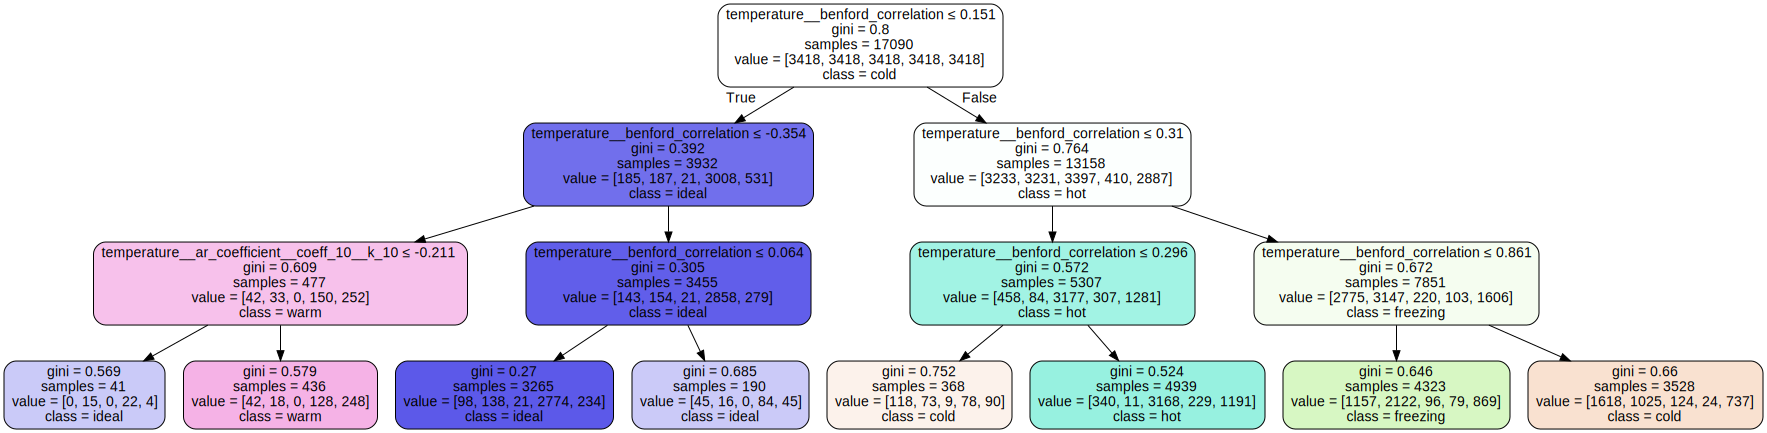

In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
clf_ar = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',tree.DecisionTreeClassifier(random_state=42,max_depth=3))])
#clf_tree = tree.DecisionTreeClassifier(random_state=42,max_depth=4)


clf_ar.fit(X=x_ar,y=y_temp["label_shifted"])

names = list(y_temp["label_shifted"].unique())
names.sort()
tree_dir = r'C:\Users\AliHa\Desktop\Masters Project\medangel\reports\figures\tree_benford.gv'
dot_data = tree.export_graphviz(clf_ar['classifier'],
                     #out_file=tree_dir,
                     feature_names = clf_ar.named_steps["augmenter"].relevant_features,
                     class_names = names,
                     filled = True,
                     rounded=True,
                     special_characters = True,
                     rotate=False
                     )
graph = graphviz.Source(dot_data)
graph


In [15]:
graph.render(tree_dir,view=True)

'C:\\Users\\AliHa\\Desktop\\Masters Project\\medangel\\reports\\figures\\tree_benford.gv.pdf'